# Ames Housing - LASSO (Least Absolute Shrinkage and Selection Operator)
- Author: Oliver Mueller
- Last update: 26.01.2024

## Initialize notebook
Load required packages. Set up workspace, e.g., set theme for plotting and initialize the random number generator.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
plt.style.use('fivethirtyeight')

## Problem description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 76 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset challenges you to predict the final price of each home. More: <https://www.kaggle.com/c/house-prices-advanced-regression-techniques>


## Load data

Load training data from CSV file.

In [3]:
data = pd.read_csv('data/train.csv')

In [4]:
data.head()

,house_id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ThreeSsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20,RL,80,10400,Pave,none,Reg,Lvl,AllPub,...,0,0,0,MnPrv,0,6,2009,WD,Family,152000
1,2,60,RL,0,28698,Pave,none,IR2,Low,AllPub,...,0,225,0,none,0,6,2009,WD,Abnorml,185000
2,3,90,RL,70,9842,Pave,none,Reg,Lvl,AllPub,...,0,0,0,none,0,3,2007,WD,Normal,101800
3,4,90,RL,60,7200,Pave,none,Reg,Lvl,AllPub,...,0,0,0,none,0,6,2009,WD,Normal,90000
4,5,190,RM,63,7627,Pave,none,Reg,Lvl,AllPub,...,0,0,0,none,0,10,2009,WD,Normal,94550


## Prepare data

First, we will remove some columns that are not useful for our task.

In [5]:
data = data.drop(['house_id', 'YrSold', 'MoSold', 'SaleCondition', 'SaleType'], axis=1)

Next, we will split the data into features (*X*) and labels (*y*) and into training (*X_train, y_train*) and test (*X_test, y_test*) sets.

In [6]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Finally, we will do some feature engineering. It is important to use only information from the training set for feature engineering, and the mechanistically repeat these steps on the test set.

Typically, feature engineering depends strongly on the datatype of the variables. Hence, we will first determine which variables are categorical and which are numerical. Subsequentally, we will transform these variables seperately.

In [7]:
categorical_features = X_train.select_dtypes(include='object').columns
numerical_features = X_train.select_dtypes(exclude='object').columns

The categorical variables must be transformed into numerical representations, e.g., by one-hot encdoing them.

In [8]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(X_train[categorical_features])

X_train_cat = enc.transform(X_train[categorical_features])
X_test_cat = enc.transform(X_test[categorical_features])

X_train_cat = pd.DataFrame(X_train_cat, columns=enc.get_feature_names_out(categorical_features))
X_test_cat = pd.DataFrame(X_test_cat, columns=enc.get_feature_names_out(categorical_features))

In [9]:
X_train_cat.head()

,MSZoning_A(agr),MSZoning_C(all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,...,GarageCond_TA,GarageCond_none,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_none
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


The numerical variables will be standardized, that is, we will subtract the mean and divide by the standard deviation. This is especially important for LASSO, as all coefficients need to be comparable in terms of units and magnitudes.

In [10]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features]) 

X_train_num = scaler.transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

X_train_num = pd.DataFrame(X_train_num, columns=numerical_features)
X_test_num = pd.DataFrame(X_test_num, columns=numerical_features)

In [11]:
X_train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,MiscVal
0,2.394594,-0.998884,-0.964781,0.671861,-0.528618,1.101158,0.960866,-0.290751,-0.969935,-0.293955,...,-0.929768,0.341572,-0.411812,-0.747661,-0.116853,-0.363305,-0.106132,-0.296792,-0.072239,-0.090035
1,0.527998,-1.704399,1.210361,-0.043088,1.276772,-0.156698,-0.866729,-0.578245,-0.969935,-0.293955,...,0.610263,0.341572,-0.168654,3.923522,2.723148,-0.363305,-0.106132,-0.296792,17.507890,-0.090035
2,-0.871949,1.147058,0.210718,-0.758036,-0.528618,0.108114,-0.481972,-0.578245,0.496704,-0.293955,...,-0.929768,0.341572,-0.131245,-0.747661,-0.696446,-0.363305,-0.106132,-0.296792,-0.072239,-0.090035
3,1.461296,-1.704399,-0.895097,0.671861,-0.528618,1.101158,0.960866,-0.474747,-0.969935,-0.293955,...,0.610263,0.341572,-0.327642,0.400206,-0.406650,-0.363305,-0.106132,-0.296792,-0.072239,-0.090035
4,-0.871949,0.647318,-0.270732,-0.758036,-0.528618,-0.355307,-1.155297,-0.578245,1.458978,0.608922,...,2.150294,-0.989920,-0.547419,-0.747661,-0.696446,-0.363305,-0.106132,-0.296792,-0.072239,-0.090035


Let's fuse the enginnered categorical and numerical variables again.

In [12]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [13]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageCond_TA,GarageCond_none,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_none
0,2.394594,-0.998884,-0.964781,0.671861,-0.528618,1.101158,0.960866,-0.290751,-0.969935,-0.293955,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.527998,-1.704399,1.210361,-0.043088,1.276772,-0.156698,-0.866729,-0.578245,-0.969935,-0.293955,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.871949,1.147058,0.210718,-0.758036,-0.528618,0.108114,-0.481972,-0.578245,0.496704,-0.293955,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.461296,-1.704399,-0.895097,0.671861,-0.528618,1.101158,0.960866,-0.474747,-0.969935,-0.293955,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.871949,0.647318,-0.270732,-0.758036,-0.528618,-0.355307,-1.155297,-0.578245,1.458978,0.608922,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## LASSO regression

We will start by initializing a LASSO model with an arbitrary lambda (called *alpha* in sklearn) value and fitting it on the training data.

In [14]:
lasso_mod = Lasso(alpha=1)
lasso_mod.fit(X_train, y_train)

Lasso(alpha=1)

Evaluate the model on both training and test set using *R2* and *RMSE* as metrics.

In [15]:
# Training data
pred_train = lasso_mod.predict(X_train)
r2_train = r2_score(y_train, pred_train)
rmse_train = root_mean_squared_error(y_train, pred_train)
print('R2 on training set:', round(r2_train, 2))
print('RMSE on training set:', round(rmse_train, 2))

print("===")

# Test data
pred_test = lasso_mod.predict(X_test)
r2_test = r2_score(y_test, pred_test)
rmse_test = root_mean_squared_error(y_test, pred_test)
print('R2 on test set:', round(r2_test, 2))
print('RMSE on test set:', round(rmse_test, 2))

R2 on training set: 0.93
RMSE on training set: 20678.9
===
R2 on training set: 0.84
RMSE on test set: 29355.02


Next, we will try 100 different lambda (*alpha*) values between 0 and 1000. The loop below fits 100 different LASSO models, each with a different alpha, and collects the test set RMSE and the estimated coefficients in a dataframe.

In [16]:
alphas = np.linspace(0, 1000, 100)

lasso_mod = Lasso()

results = []
for a in alphas:
    result = {}
    lasso_mod.set_params(alpha=a)
    lasso_mod.fit(X_train, y_train)
    pred_test = lasso_mod.predict(X_test)

    rmse_test = root_mean_squared_error(y_test, pred_test)
    
    coef_names = lasso_mod.feature_names_in_
    coef_values = lasso_mod.coef_

    result["alpha"] = a
    result["rmse"] = rmse_test
    for i in range(0, len(coef_names)):
        result[coef_names[i]] = coef_values[i]

    results.append(result)


In [17]:
results_df = pd.DataFrame(results)
results_df.head()

,alpha,rmse,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,GarageCond_TA,GarageCond_none,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_none
0,0.00000,29819.513038,-6930.426092,466.246866,6233.625747,9101.326417,7282.432108,9778.758132,1718.855636,2032.497475,...,33.598059,-8.980521,-1897.391362,-2220.851446,47.056091,-7114.613885,1968.675374,2484.113640,3675.376267,-182.457812
1,10.10101,28137.246856,-5685.286467,385.584094,5730.848288,9228.682542,7191.573876,9762.714904,1874.540114,1893.572568,...,3536.573212,0.000000,-0.000000,-0.000000,1601.194049,-7868.154541,0.000000,352.642184,0.000000,-2118.078126
2,20.20202,27198.859369,-5420.534528,317.239981,5289.239151,9653.449001,7120.529498,9664.778333,1950.198615,1823.036117,...,3178.680651,0.000000,-0.000000,-0.000000,1185.363630,-6185.344594,0.000000,771.543772,0.000000,-1464.473577
3,30.30303,26456.419151,-5426.888349,215.090513,4988.154726,10040.789644,7146.672439,9374.611225,1900.995367,1793.721171,...,3252.661904,0.000000,-0.000000,-0.000000,871.185745,-4820.851857,0.000000,1032.266955,0.000000,-826.229541
4,40.40404,25848.027403,-5591.638466,119.413356,4746.928594,10393.209809,7168.154868,9236.438468,1880.259171,1768.991679,...,2740.038715,0.000000,-0.000000,-0.000000,514.974172,-3695.637787,0.000000,1386.909038,0.000000,-199.336413


Let's visualize how the coefficients shrink with increasing alpha.

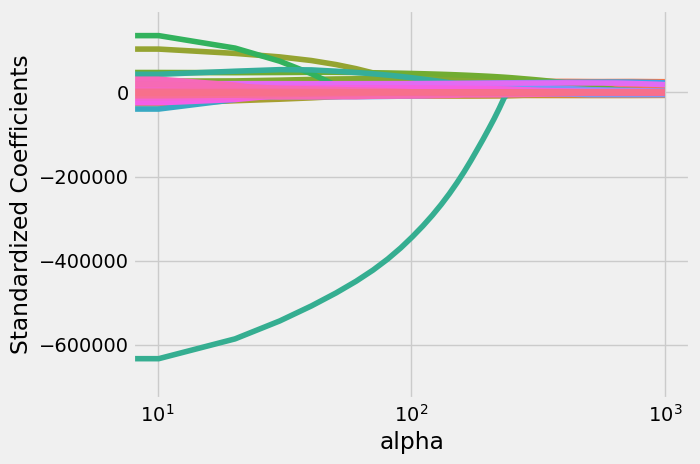

In [18]:
# wrangle the data into long format
results_df_long = pd.melt(results_df.drop(['alpha', 'rmse'], axis=1), value_vars=results_df.columns[2:])
alphas_m = np.tile(results_df["alpha"].to_numpy(), 283)
rmses_m = np.tile(results_df["rmse"].to_numpy(), 283)
results_df_long["alpha"] = alphas_m
results_df_long["rmse"] = rmses_m

# create lineplot
sns.lineplot(data=results_df_long, x=results_df_long["alpha"], y=results_df_long["value"], hue=results_df_long["variable"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.legend().remove()
plt.show()

Similarily, we can plot the test set RMSE against alpha.

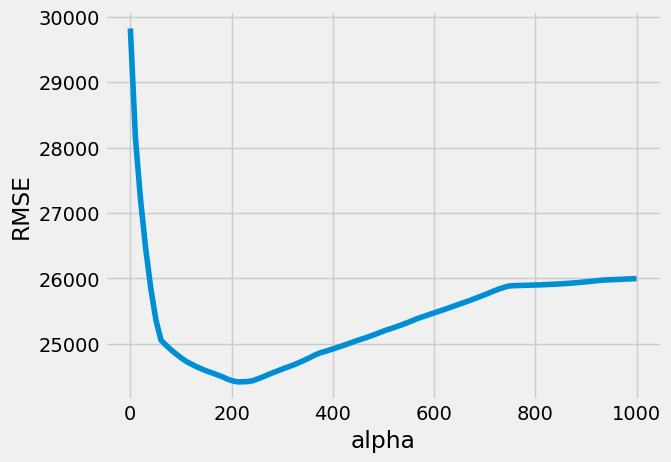

In [19]:
sns.lineplot(data=results_df_long, x=results_df_long["alpha"], y=results_df_long["rmse"])
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.show()


## Hyperparameter tuning

A more robust way to choose the alpha value that leads to the best out-of-sample predictive accuracy is to use k-fold cross validation (we might just have been lucky with the above train/test split).

In [20]:
lasso_mod_cv = LassoCV(cv=5, alphas=alphas, random_state=42)
lasso_mod_cv.fit(X_train, y_train)

LassoCV(alphas=array([    0.        ,   101.01010101,   202.02020202,   303.03030303,
         404.04040404,   505.05050505,   606.06060606,   707.07070707,
         808.08080808,   909.09090909,  1010.1010101 ,  1111.11111111,
        1212.12121212,  1313.13131313,  1414.14141414,  1515.15151515,
        1616.16161616,  1717.17171717,  1818.18181818,  1919.19191919,
        2020.2020202 ,  2121.21212121,  2222.22222222,  2323.23232323,
        2424.24242424,...
        7676.76767677,  7777.77777778,  7878.78787879,  7979.7979798 ,
        8080.80808081,  8181.81818182,  8282.82828283,  8383.83838384,
        8484.84848485,  8585.85858586,  8686.86868687,  8787.87878788,
        8888.88888889,  8989.8989899 ,  9090.90909091,  9191.91919192,
        9292.92929293,  9393.93939394,  9494.94949495,  9595.95959596,
        9696.96969697,  9797.97979798,  9898.98989899, 10000.        ]),
        cv=5, random_state=42)

Which alpha value leads to the best out-of-sample predictive accuracy?

In [21]:
lasso_mod_cv.alpha_

101.01010101010101

Refit the model with the best alpha value.

In [22]:
lasso_mod_tuned = Lasso(alpha=lasso_mod_cv.alpha_)
lasso_mod_tuned.fit(X_train, y_train)

Lasso(alpha=101.01010101010101)

Evaluate this model on the test set.

In [23]:
# Training data
pred_train = lasso_mod_tuned.predict(X_train)
r2_train = r2_score(y_train, pred_train)
rmse_train = root_mean_squared_error(y_train, pred_train)
print('R2 on training set:', round(r2_train, 2))
print('RMSE on training set:', round(rmse_train, 2))

print("===")

# Test data
pred_test = lasso_mod_tuned.predict(X_test)
r2_test = r2_score(y_test, pred_test)
rmse_test = root_mean_squared_error(y_test, pred_test)
print('R2 on test set:', round(r2_test, 2))
print('RMSE on test set:', round(rmse_test, 2))

R2 on training set: 0.91
RMSE on training set: 23284.81
===
R2 on training set: 0.89
RMSE on test set: 24782.3


## A secret weapon: LASSO with A LOT OF interaction terms

The automatic feature selection capability of LASSO can be used to identify important interaction terms. In the following, we will add all possible interaction terms to the feature matrix, use cross-validation to identify the best lambda/alpha value, and then refit and evaluate a final model.

Check dimensions of *X_train*.

In [24]:
X_train.shape

(1875, 283)

Use the *PolynomialFeatures* transformer to create all possible two-way combinations of features.

In [25]:
interact = PolynomialFeatures(interaction_only=True)

X_train_interact = interact.fit_transform(X_train)
X_train_interact = pd.DataFrame(X_train_interact, columns=interact.get_feature_names_out())

X_test_interact = interact.transform(X_test)
X_test_interact = pd.DataFrame(X_test_interact, columns=interact.get_feature_names_out())

Check dimensions of *X_train_interact*.

In [26]:
X_train_interact.shape

(1875, 40187)

Let's have a look at the feature matrix.

In [27]:
X_train_interact.head()

,1,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Fence_GdPrv Fence_GdWo,Fence_GdPrv Fence_MnPrv,Fence_GdPrv Fence_MnWw,Fence_GdPrv Fence_none,Fence_GdWo Fence_MnPrv,Fence_GdWo Fence_MnWw,Fence_GdWo Fence_none,Fence_MnPrv Fence_MnWw,Fence_MnPrv Fence_none,Fence_MnWw Fence_none
0,1.0,2.394594,-0.998884,-0.964781,0.671861,-0.528618,1.101158,0.960866,-0.290751,-0.969935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.527998,-1.704399,1.210361,-0.043088,1.276772,-0.156698,-0.866729,-0.578245,-0.969935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,-0.871949,1.147058,0.210718,-0.758036,-0.528618,0.108114,-0.481972,-0.578245,0.496704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.461296,-1.704399,-0.895097,0.671861,-0.528618,1.101158,0.960866,-0.474747,-0.969935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,-0.871949,0.647318,-0.270732,-0.758036,-0.528618,-0.355307,-1.155297,-0.578245,1.458978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As done before, we now perform k-fold cross validation to search for best lambda/alpha value and then refit the model with this parameter. WARNING: The next cell might take a while to run (approx. 15mins).

In [28]:
alphas = np.linspace(0, 10000, 100)
lasso_mod_interact_cv = LassoCV(cv=2, alphas=alphas, random_state=42)
lasso_mod_interact_cv.fit(X_train_interact, y_train)

LassoCV(alphas=array([    0.        ,   101.01010101,   202.02020202,   303.03030303,
         404.04040404,   505.05050505,   606.06060606,   707.07070707,
         808.08080808,   909.09090909,  1010.1010101 ,  1111.11111111,
        1212.12121212,  1313.13131313,  1414.14141414,  1515.15151515,
        1616.16161616,  1717.17171717,  1818.18181818,  1919.19191919,
        2020.2020202 ,  2121.21212121,  2222.22222222,  2323.23232323,
        2424.24242424,...
        7676.76767677,  7777.77777778,  7878.78787879,  7979.7979798 ,
        8080.80808081,  8181.81818182,  8282.82828283,  8383.83838384,
        8484.84848485,  8585.85858586,  8686.86868687,  8787.87878788,
        8888.88888889,  8989.8989899 ,  9090.90909091,  9191.91919192,
        9292.92929293,  9393.93939394,  9494.94949495,  9595.95959596,
        9696.96969697,  9797.97979798,  9898.98989899, 10000.        ]),
        cv=2, random_state=42)

In [29]:
lasso_mod_interact_tuned = Lasso(alpha=lasso_mod_interact_cv.alpha_)
lasso_mod_interact_tuned.fit(X_train_interact, y_train)

Lasso(alpha=1414.141414141414)

Evaluate the tuned LASSO model with all possible two-way interactions on the test set.

In [30]:
# Training data
pred_train = lasso_mod_interact_tuned.predict(X_train_interact)
r2_train = r2_score(y_train, pred_train)
rmse_train = root_mean_squared_error(y_train, pred_train)
print('R2 on training set:', round(r2_train, 2))
print('RMSE on training set:', round(rmse_train, 2))

print("===")

# Test data
pred_test = lasso_mod_interact_tuned.predict(X_test_interact)
r2_test = r2_score(y_test, pred_test)
rmse_test = root_mean_squared_error(y_test, pred_test)
print('R2 on test set:', round(r2_test, 2))
print('RMSE on test set:', round(rmse_test, 2))

R2 on training set: 0.93
RMSE on training set: 21289.09
===
R2 on training set: 0.93
RMSE on test set: 20035.43
